# About
Algoritma: Particle Swarm Optimization + Firefly Algorithm <br>
Fungsi: F7 (Noisy Quartic Function) <br>
Domain: \[-0.3, 0.8\]


# Setup & Utilities

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Color map
import numpy as np

# GIF utilities
import PIL
from IPython.display import display, Image

# utilities
import math 
import random

DEFAULT_LOWER_DOMAIN = -1.28
DEFAULT_UPPER_DOMAIN = 1.28
LOWER_DOMAIN = -0.3
UPPER_DOMAIN = 0.8

In [2]:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/contour_demo.html
class Plotter:
    def __init__(self, function):
        self.spec = {
            "point_color": "white",
            "best_point_color": "red",
            "point_radius": 7,
            "arrow_head_width": 0.025,
            "arrow_head_length": 0.025,
        }

        self.function = function
        
        delta = 0.02
        x_axes = np.arange(LOWER_DOMAIN, UPPER_DOMAIN, delta)
        y_axes = np.arange(LOWER_DOMAIN, UPPER_DOMAIN, delta)
        self.X_AXES, self.Y_AXES = np.meshgrid(x_axes, y_axes)
        self.Z = self.function(self.X_AXES, self.Y_AXES)

    def locate_points(self, particles):
        for particle in particles:
            if hasattr(particle, "current_velocity"):
                # Normalize vector then scale down
                normalizer = math.sqrt(
                    math.pow(particle.get_velocity("x"), 2) 
                    + math.pow(particle.get_velocity("y"), 2)
                )*32

                plt.arrow(
                    particle.get_position("x"), 
                    particle.get_position("y"),
                    particle.get_velocity("x") / normalizer, 
                    particle.get_velocity("y") / normalizer,
                    color=self.spec["point_color"], 
                    head_width= self.spec["arrow_head_width"], 
                    head_length= self.spec["arrow_head_length"]
                )

            plt.scatter(
                particle.get_position("x"), 
                particle.get_position("y"),
                s = (
                    self.spec["point_radius"] if not(particle.is_best())
                    else self.spec["point_radius"]*2
                ),
                color = (
                    self.spec["point_color"] if not(particle.is_best())
                    else self.spec["best_point_color"]
                ),
                label = 'Point'
            )
                
    def plot_current_status(self, particles):
        #plt.clf()
        plt.contourf(self.X_AXES, self.Y_AXES, self.Z)
        plt.axis('scaled')
        plt.colorbar()
        self.locate_points(particles)
        #plt.show()

    def plot_objective_function(self):
        h = plt.contourf(self.X_AXES, self.Y_AXES, self.Z)
        plt.axis('scaled')
        plt.colorbar()
        plt.show()
    

In [3]:
def generate_GIF(history, filename, frame_duration):
    image_buffer = []
    for hist in history:
        image_buffer.append(PIL.Image.open(hist))

    image_buffer[0].save(
        filename, 
        save_all=True, 
        append_images=image_buffer[1:], 
        loop=0, 
        duration=frame_duration
    )
    display(Image(filename=filename))

# Noisy Quartic Function
Fungsi ini merupakan fungsi Quartic yang ditambahkan dengan noise berupa nilai acak antara 0 hingga 1. Adapun spesifikasi dan ilustrasi dari fungsi ini yakni <br>
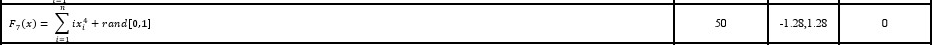

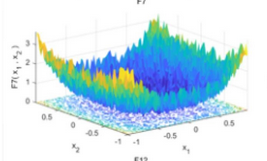


In [4]:
# point-wise random
def objective_function(x1, x2):
    NOISE = np.random.rand(*x1.shape)    
    return (np.power(x1, 4) + 2*np.power(x2, 4) + NOISE)

#
PLOTTER = Plotter(objective_function)

# Fitness Function
Berdasarkan batasan yang didefinisikan, fungsi ini hanya akan menerima dua nilai x: x1 dan x2. <br>

Karena masalah yang diangkat adalah minimasi fungsi, artinya semakin kecil nilai fungsi ketika nilai x tersebut dimasukkan, semakin bagus nilai fitness yang didapatkan. Dengan begitu, nilai fitness dengan nilai fungsi saling berbanding terbalik

In [5]:
# Fungsi ingin diminimasi, sehingga semakin kecil nilai fungsi,
# fitness samakin baik (saling berbanding terbalik)
def fitness(particle):
    function_value = objective_function(
        np.array([particle.get_position("x")]),
        np.array([particle.get_position("y")])
    )[0];

    # special case
    if(function_value == 0):
        return -1
        
    return 1 / function_value

# Particle Swarm Optimization (PSO)
## Intuisi Cara Kerja
1. Inisialisasi partikel sebanyak N yang akan digunakan untuk mencari solusi sehingga nilai fungsi objektif menjadi minimum
2. Inisialisasi pula sejumlah parameter untuk mengatur jalannya algoritma ini
    - `nPartikel`: Banyaknya partikel yang akan mencari solusi permasalahan
    - `individual_learning_rate`: Seberapa besar pengaruh partikel itu sendiri dalam mengambil keputusan ke arah mana ia harus bergerak selanjutnya
    - `group_learning_rate`: Seberapa besar pengaruh partikel terbaik dalam populasi terhadap pengambilan keputusan setiap partikel
    - `epoch`: Banyaknya perulangan proses pencarian
4. Selama belum mencapai kondisi berhenti, lakukan hal berikut:
    1. Hitung fitness dari setiap partikel
    2. Tentukan partikel mana yang memiliki fitness terbaik
    3. Perbarui kecepatan dan posisi dari partikel saat ini berdasarkan partikel terbaik dan parameter yang sebelumnya ditentukan
5. Cari partikel terbaik dan gunakan itu sebagai solusi terbaik yang dapat ditemukan

## Pengaturan parameter
Berikut adalah pengaturan yang digunakan:
- `individual_learning_rate` akan dibuat sama untuk setiap partikel,
- `group_learning_rate` dibuat lebih besar dari `individual_learning_rate` (rasio 4:3) agar partikel masih bisa keluar dari jebakan minimum lokal,
- `epoch` dibuat sedikit karena ini jika terlalu besar, maka partikel akan melewati kemungkinan solusi optimal (overshoot). Untuk kembali ke tempat tersebut, akan dibutuhkan epoch yang lebih banyak lagi karena kecepatan sudah diberi skala tertentu agar tidak terlalu cepat,
- `nParticle` dibuat 25 karena ini jumlah ini sudah cukup banyak

## Definisi komponen

### Kelas Partikel

In [6]:
class Particle:
    MAX_VELOCITY = 0.55*10e-2
    
    def __init__(self, init_position: dict, init_velocity: dict):
        self.current_position = init_position
        self.current_velocity = init_velocity
  
        self.best_position = init_position
        self.best_fitness = 0;
        self.current_fitness = 0;
        
        self.is_best_particle = False;


    def get_position(self, axis): return self.current_position[axis]
    def get_velocity(self, axis): return self.current_velocity[axis]
    def get_current_fitness(self): return self.current_fitness
    def get_best_fitness(self): return self.best_fitness
    def is_best(self): return self.is_best_particle
        
    def update_velocity(self, new_velocity):
        for axis in "xy":
            if new_velocity[axis] > self.MAX_VELOCITY:
                new_velocity[axis] = self.MAX_VELOCITY
            elif new_velocity[axis] < -self.MAX_VELOCITY:
                new_velocity[axis] = -self.MAX_VELOCITY
        
        self.current_velocity = new_velocity

    def update_position(self, new_position):
        for axis in "xy":
            if new_position[axis] > UPPER_DOMAIN:
                new_position[axis] = UPPER_DOMAIN
            elif new_position[axis] < LOWER_DOMAIN:
                new_position[axis] = LOWER_DOMAIN

        if self.current_fitness > self.best_fitness:
            self.best_fitness = self.current_fitness
            self.best_position = self.current_position
            
        self.current_position = new_position

    def update_current_fitness(self, fitness):
        self.current_fitness = fitness
        
    def update_is_best(self, is_best):
        self.is_best_particle = is_best;
        
    def self_best_diff(self):
        return {
            axis: (self.best_position[axis] - self.current_position[axis])
            for axis in "xy"
        }

Best solution:
0.21615210589685624 , -0.0305577700984588
Final solution (w/o noise): 0.0021846642037927494


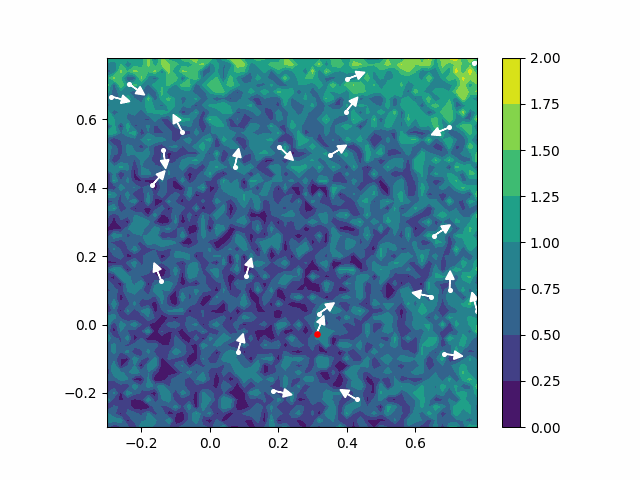

In [19]:
def PSO_optimizer():
    # Utilities
    PLOT_HISTORY = []
    
    # Initialize particles
    nParticles = 25
    velocity_scaler = 10e6
    
    particles = [
        Particle({"x": random.uniform(LOWER_DOMAIN, UPPER_DOMAIN), 
                  "y": random.uniform(LOWER_DOMAIN, UPPER_DOMAIN)}, 
                {"x": random.uniform(LOWER_DOMAIN, UPPER_DOMAIN) / velocity_scaler, 
                 "y": random.uniform(LOWER_DOMAIN, UPPER_DOMAIN) / velocity_scaler}) 
        for _ in range(nParticles)
    ]

    # Parameter settings
    EPOCH = 10
    INDIVIDUAL_LEARNING_RATE = 0.045
    GROUP_LEARNING_RATE = 0.060

    # Optimization
    best_particle = None
    best_fitness = 0
    for ep in range(EPOCH):
        # Which particle has the best solution?
        for particle in particles:
            if not(particle.is_best()):
                particle.update_is_best(False)

                
            particle.update_current_fitness(fitness(particle))
            hasBetterFitness = (
                particle.get_current_fitness() == -1
                or (
                    best_fitness != -1
                    and particle.get_current_fitness() > best_fitness
                )
            )

            if hasBetterFitness:
                if best_particle != None:
                    best_particle.update_is_best(False)
                particle.update_is_best(True)
                best_particle = particle
                best_fitness = best_particle.get_current_fitness()
            
        PLOTTER.plot_current_status(particles)
        filename = f"PSOe{ep}.png"
        plt.savefig(filename)
        plt.close()
        PLOT_HISTORY.append(filename)
        
        # Update velocity and position
        for particle in particles:
            individual_best_difference = particle.self_best_diff()
            group_best_difference = {
                axis: (best_particle.best_position[axis] - particle.current_position[axis])
                for axis in "xy"
            }
            
            new_velocity = {
                axis: (
                    particle.get_velocity(axis) 
                    + INDIVIDUAL_LEARNING_RATE*individual_best_difference[axis]*random.uniform(0, 1)
                    + GROUP_LEARNING_RATE*group_best_difference[axis]*random.uniform(0, 1)
                ) for axis in "xy"
            }

            new_position = {
                axis: particle.get_position(axis) + new_velocity[axis]
                for axis in "xy"
            }

            particle.update_position(new_position)
            particle.update_velocity(new_velocity)

    global_minimum_diff = objective_function(
            np.array(best_particle.get_position("x")),
            np.array(best_particle.get_position("y"))
    );
    
    print("Best solution:")
    print(" , ".join([str(best_particle.get_position(ax)) for ax in "xy"]))
    print(f"Final solution (w/o noise): {np.power(best_particle.get_position("x"), 4) + 2*np.power(best_particle.get_position("y"), 4)}")

    # Generate GIF =================================
    generate_GIF(PLOT_HISTORY, "PSO_result.gif", 400)
        
PSO_optimizer()

## Firefly Algorithm (FA)
## Intuisi Cara Kerja
1. Inisialisasi `Firefly` sebanyak N yang akan digunakan untuk mencari solusi sehingga nilai fungsi objektif menjadi minimum
2. Inisialisasi pula sejumlah parameter untuk mengatur jalannya algoritma ini
    - `attractiveness` yang merupakan seberapa besar pengaruh `Firefly` ini seandainya `Firefly` lain bergerak ke arahnya
    - `epoch` yang merupakan banyaknya iterasi yang akan dilakukan
    - `nFirefly` yang merupakan berapa banyak `Firefly` yang akan digunakan untuk melakukan pencarian
4. Hitung nilai fitness awal dari setiap `Firefly`
5. Selama belum mencapai kondisi berhenti, untuk setiap `Firefly`, lakukan hal berikut:
   1. Bandingkan intensitas dari `Firefly` ini dengan `Firefly` lainnya
   2. Jika `Firefly` lain memiliki intensitas yang lebih tinggi (bisa dikatakan sebagai memiliki nilai fitness yang lebih baik), maka `Firefly` harus bergerak ke arah `Firefly` tersebut. Jika tidak, maka `Firefly` akan melakukan gerak secara acak. 
   3. Banyaknya perpindahan yang dilakukan dipengaruhi oleh `attractiveness` yang dimiliki oleh `Firefly` tujuan tersebut dan seberapa jauh ia dengan `Firefly` yang bergerak
6. Cari `Firefly` dengan fitness terbaik dan gunakan itu sebagai solusi terbaik yang dapat ditemukan

## Pengaturan parameter
Berikut adalah pengaturan yang digunakan:
- `attractiveness` dibuat sama untuk semua `Firefly` karena pada awal, `Firefly` mana yang harus dibuat lebih atraktif agar lebih cepat mencapai titik optimal tidak diketahui
- `epoch` yang digunakan adalah 5 karena jika lebih dari angka tersebut, hasil tidak akan berubah lebih jauh (sudah mendekati plateau)
- `nFirefly` dibuat 10 karena jika terlalu banyak, optimisasi akan berjalan lebih lama (Kompleksitas O(n^2))

In [8]:
class Firefly:
    LIGHT_ABSORPTION = 5e-6
    MOVEMENT_SCALER = 10
    
    def __init__(self, init_position: dict):
        self.current_position = init_position
        self.attractiveness = 1 
        self.light_intensity = 0 # Synonymous to fitness, I guess?
        self.is_best_firefly = False
        
    def get_distance_from(self, position):
        position_diff =  {
            axis: math.pow(self.current_position[axis] - position[axis], 2)
                for axis in "xy"
        }
        
        return math.sqrt(sum([position_diff[ax] for ax in "xy"]))

    # Intensity varies based on distance between two fireflies
    # https://medium.com/@shantanuparab99/firefly-algorithm-bio-inspired-decision-making-algorithm-d25941725d14
    def light_intensity_from(self, position):
        distance = self.get_distance_from(position)
        return self.light_intensity*math.exp(-self.LIGHT_ABSORPTION*(distance**2))

    def attractiveness_from(self, position):
        distance = self.get_distance_from(position)
        return self.attractiveness*math.exp(-self.LIGHT_ABSORPTION*(distance**2))

    def get_light_intensity(self): return self.light_intensity
    def get_attractiveness(self): return self.attractiveness
    def get_current_position(self): return self.current_position
    def get_position(self, axis): return self.current_position[axis]
    def is_best(self): return self.is_best_firefly
        
    def update_is_best(self, is_best):
        self.is_best_firefly = is_best;
        
    def set_attractiveness(self, new_attractiveness):
        self.attractiveness = new_attractiveness
        
    def set_light_intensity(self, new_intensity): 
        self.light_intensity = new_intensity

    def move_towards(self, target):
        direction = {
            axis: (1 if self.current_position[axis] < target.get_position(axis) else -1)
            for axis in "xy"
        }
        
        distance = self.get_distance_from(target.get_current_position())
        new_position = {
            axis: self.current_position[axis] + 
                (self.attractiveness_from(target.get_current_position())*distance/(self.MOVEMENT_SCALER) +
                0) * direction[axis]
            for axis in "xy"
        }

        for axis in "xy":
            if new_position[axis] > UPPER_DOMAIN:
                new_position[axis] = UPPER_DOMAIN
            elif new_position[axis] < LOWER_DOMAIN:
                new_position[axis] = LOWER_DOMAIN
                
        self.current_position = {axis: new_position[axis] for axis in "xy"};
        
    def random_fly(self):
        new_position = {axis: self.current_position[axis] + random.uniform(-0.00625, 0.00625) for axis in "xy"}
        for axis in "xy":
            if new_position[axis] > UPPER_DOMAIN:
                new_position[axis] = UPPER_DOMAIN
            elif new_position[axis] < LOWER_DOMAIN:
                new_position[axis] = LOWER_DOMAIN
                
        self.current_position = {axis: new_position[axis] for axis in "xy"};


Best solution:
0.17330409883652984 , -0.07317467138787262
Final solution (w/o noise): 0.000959401854922802


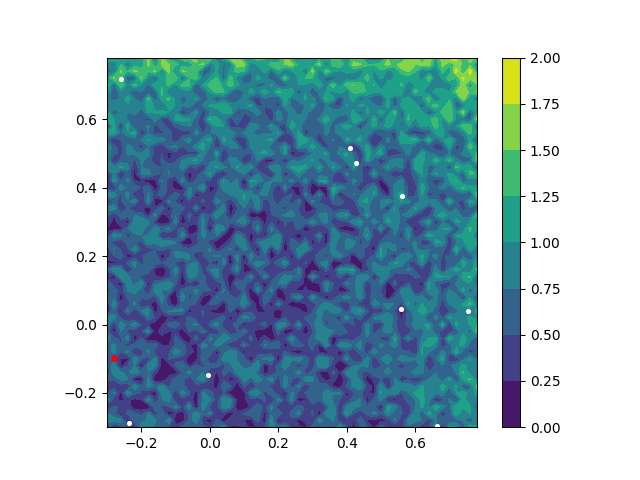

In [24]:
def FA_optimizer():
    PLOT_HISTORY = []

    # Initialize fireflies
    nFireflies = 10
    fireflies = [
        Firefly({"x": random.uniform(LOWER_DOMAIN, UPPER_DOMAIN), 
                  "y": random.uniform(LOWER_DOMAIN, UPPER_DOMAIN)}, 
                ) 
        for _ in range(nFireflies)
    ]

        
    best_fly = fireflies[0]
    best_fly.update_is_best(True)
    for fly in fireflies:
        fly.set_light_intensity(fitness(fly))
        if fly.get_light_intensity() > best_fly.get_light_intensity():
            best_fly.update_is_best(False)
            best_fly = fly
            best_fly.update_is_best(True)
            
    PLOTTER.plot_current_status(fireflies)
    filename = f"FA-init.png"
    plt.savefig(filename)
    plt.close()
    PLOT_HISTORY.append(filename)

    """
    for f in fireflies:
        print(f.get_position("x"), f.get_position("y"))
    """

    EPOCH = 5
    for ep in range(EPOCH):
        for fly in fireflies:
            for (idx, other_fly) in enumerate(fireflies):
                if not(fly is other_fly):
                    filename = f"FAe{ep}_mov-{len(PLOT_HISTORY)}.png"
                    
                    if fly.get_light_intensity() < other_fly.light_intensity_from(fly.get_current_position()):
                        fly.move_towards(other_fly)
                    else:
                        fly.random_fly()
                    

                    PLOTTER.plot_current_status(fireflies)
                    plt.savefig(filename)
                    plt.close()
                    PLOT_HISTORY.append(filename)
                        
            fly.set_light_intensity(fitness(fly))
        if fly.get_light_intensity() > best_fly.get_light_intensity(): 
            best_fly.update_is_best(False)
            best_fly = fly
            best_fly.update_is_best(True)
                        
            
        
        PLOTTER.plot_current_status(fireflies)
        filename = f"FAe{ep}.png"
        plt.savefig(filename)
        plt.close()
        PLOT_HISTORY.append(filename)
        
    print("Best solution:")
    print(" , ".join([str(best_fly.get_position(ax)) for ax in "xy"]))
    print(f"Final solution (w/o noise): {np.power(best_fly.get_position("x"), 4) + 2*np.power(best_fly.get_position("y"), 4)}")
    generate_GIF(PLOT_HISTORY, "FA_result.gif", 100)

FA_optimizer()